<a href="https://colab.research.google.com/github/AmaanRai1/DS-440---Group-2/blob/main/mainV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization
import requests

# Import PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from io import StringIO

#from v2 import main


from sklearn.preprocessing import MinMaxScaler # preprocessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # evaluation metrics
from sklearn.linear_model import LinearRegression # linear regression model

from itertools import product # Import itertools for generating combinations
import heapq # Import heapq for getting top elements from a list
from joblib import Parallel, delayed

## **Data**

In [3]:

index_name = "DJI"
# Step 1: Function to get TEMA parameters based on the stock index
def get_best_tema_params(index_name):
    if index_name == 'IBEX':
        best_tema_params = [2, 5, 8]
    elif index_name == 'DJI':
        best_tema_params = [19, 36, 57]
    else:
        best_tema_params = [15, 16, 17]
    return best_tema_params

# Step 2: Function to load CSV from GitHub URL using requests
def load_data_from_github(index_name):
    base_url = "https://raw.githubusercontent.com/AmaanRai1/DS-440---Group-2/main/"

    if index_name == "DJI":
        file_url = f"{base_url}dji.csv"
    elif index_name == "GDAXI":
        file_url = f"{base_url}gdaxi.csv"
    elif index_name == "IBEX":
        file_url = f"{base_url}ibex.csv"
    else:
        raise ValueError(f"Invalid index name: {index_name}")

    response = requests.get(file_url)
    response.raise_for_status()  # Raise HTTPError for bad responses (e.g., 404)
    csv_content = StringIO(response.text)
    df = pd.read_csv(csv_content)

    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
    df.set_index('Date', inplace=True)
    df = df.drop(['Volume', 'Adj Close'], axis=1, errors='ignore')

    return df

# Step 3: Function to split data into train, validation, and test sets
def split_data(df):
    split_date = pd.to_datetime('2019-01-01')
    train_data = df[df.index < split_date]
    test_data = df[df.index >= split_date]

    validation_split = int(0.8 * len(train_data))
    train_data_final = train_data.iloc[:validation_split]  # 80% for training
    validation_data = train_data.iloc[validation_split:]  # 20% for validation

    # Create and fit scaler
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data_final[['Open', 'Close', 'High', 'Low']])
    validation_data_scaled = scaler.transform(validation_data[['Open', 'Close', 'High', 'Low']])
    test_data_scaled = scaler.transform(test_data[['Open', 'Close', 'High', 'Low']])

    # Convert scaled data back to DataFrames
    train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=train_data_final.index)
    validation_data_scaled = pd.DataFrame(validation_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=validation_data.index)
    test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=test_data.index)

    # Return scaled data and the scaler
    return train_data_scaled, validation_data_scaled, test_data_scaled, scaler


# Step 4: Define the TEMA Strategy Function
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    df = df.copy()  # Create a copy of the DataFrame

    # Calculate the EMA values for short, mid, and long periods
    df['ShortEMA'] = df[symbol].ewm(span=short_period, adjust=False).mean()
    df['MidEMA'] = df[symbol].ewm(span=mid_period, adjust=False).mean()
    df['LongEMA'] = df[symbol].ewm(span=long_period, adjust=False).mean()

    # Determine the position based on EMA crossovers
    df['Position'] = np.where((df['ShortEMA'] > df['MidEMA']) & (df['ShortEMA'] > df['LongEMA']), 1,
                              np.where((df['ShortEMA'] < df['MidEMA']) & (df['ShortEMA'] < df['LongEMA']), -1, 0))

    # Calculate log returns and strategy based on log returns
    df['LogReturns'] = np.log(df[symbol]) - np.log(df[symbol].shift(1))
    df['Strategy'] = df['Position'].shift(1) * df['LogReturns']

    # Calculate cumulative returns for evaluation
    df['CumulativeLogReturns'] = df['LogReturns'].cumsum().apply(np.exp)
    df["CumulativeStrategy"] = df['Strategy'].cumsum().apply(np.exp)

    return df

# Step 5: Main Function to Run the Strategy
def main(index_name):
    # Load the data
    df = load_data_from_github(index_name)

    # Get TEMA parameters for the chosen stock index
    best_tema_params = get_best_tema_params(index_name)
    short_period, mid_period, long_period = best_tema_params

    # Split the data into train, validation, and test sets
    train_data, validation_data, test_data, scaler = split_data(df)


    # Apply TEMA strategy on test data
    tema_result = tema_strategy(test_data, 'Close', short_period, mid_period, long_period)

    # Print the first few rows of results
    print(tema_result.head())

    # Return test_data and tema_result for further use
    return test_data, tema_result

# If running this script directly, test with an example
if __name__ == "__main__":
    # Load DJI data and run the strategy
    main("DJI")







                Open     Close      High       Low  ShortEMA    MidEMA  \
Date                                                                     
2019-01-02  1.184176  1.213254  1.216624  1.182398  1.213254  1.213254   
2019-01-03  1.195417  1.150156  1.193741  1.155002  1.206944  1.209843   
2019-01-04  1.168553  1.221563  1.226775  1.179219  1.208406  1.210477   
2019-01-07  1.223847  1.230950  1.243097  1.217613  1.210660  1.211583   
2019-01-08  1.243514  1.255433  1.260172  1.244034  1.215138  1.213954   

             LongEMA  Position  LogReturns  Strategy  CumulativeLogReturns  \
Date                                                                         
2019-01-02  1.213254         0         NaN       NaN                   NaN   
2019-01-03  1.211078        -1   -0.053408 -0.000000              0.947993   
2019-01-04  1.211440        -1    0.060234 -0.060234              1.006849   
2019-01-07  1.212112        -1    0.007655 -0.007655              1.014586   
2019-01-08  1

## **Modeling and Evaluation Functions**

In [4]:
def calculate_profit_factor(strategy):
    """
    Calculate the profit factor of a trading strategy.

    Args:
        strategy (pd.Series): A pandas Series representing the strategy's trade outcomes.

    Returns:
        float: The profit factor of the strategy.
    """
    positive_trades = strategy.loc[strategy > 0].sum() # Calculate the sum of positive trades
    negative_trades = strategy.loc[strategy < 0].sum() # Calculate the sum of negative trades
    profit_factor = abs(positive_trades / negative_trades) # Calculate the profit factor
    return profit_factor

In [5]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()

    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()

    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])

    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades

    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])

    return metrics_df

# Helper function for scaler predictions
def inverse_scale_predictions(scaler, y_pred):
    return scaler.inverse_transform(y_pred)

# Helper to make predictions for validation consistency
def make_prediction_df(predictions, validation_data, time_window, column_name='Predicted'):
    y_pred_df = pd.DataFrame(predictions, columns=[column_name], index=validation_data.index[-len(predictions):])
    y_pred_df = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=[column_name]), y_pred_df], ignore_index=True)
    return y_pred_df

In [6]:
def get_y_pred_lr(model, x_data, time_window):
    """
    Generates the y_pred_lr DataFrame using the provided model, input data, and time window.

    Args:
        model: The trained regression model used for predictions.
        x_data: The input data on which predictions are to be made.
        time_window: The time window used to add NaN rows at the beginning.

    Returns:
        pd.DataFrame: DataFrame with predictions and NaN padding.
    """
    # Generate predictions
    y_pred = model.predict(x_data)

    # Convert predictions to a DataFrame
    y_pred_lr = pd.DataFrame(y_pred, columns=['Predicted'])

    # Add NaN rows at the top for the time window
    y_pred_lr = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=['Predicted']), y_pred_lr],
                          ignore_index=True)

    return y_pred_lr


In [7]:
def get_y_pred_ann(model, x_test, test_data, close_scaler, time_window):
    """
    Generate predictions using the ANN model and prepare the y_pred_ann DataFrame.

    Args:
        model (torch.nn.Module): The trained ANN model.
        x_test (torch.Tensor): Test data for generating predictions.
        test_data (pd.DataFrame): Original test data for reference dates.
        close_scaler (MinMaxScaler): Scaler used for 'Close' column inverse transformation.
        time_window (int): Number of rows to add NaN values at the top of the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with 'Predicted' column of ANN model predictions.
    """
    # Compute predictions on the test data
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)

    # Reshape y_pred to match the shape of the original data and apply inverse scaling
    y_pred = close_scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))  # Use close_scaler

    # Convert y_pred to a DataFrame and add NaN rows for initial indices
    y_pred_ann = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data.iloc[time_window:].index)
    y_pred_ann = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=['Predicted']), y_pred_ann], ignore_index=True)

    return y_pred_ann


In [8]:
def get_y_pred_lstm(model, x_test, test_data, close_scaler, time_window):
    """
    Generate predictions using the LSTM model and prepare the y_pred_lstm DataFrame.

    Args:
        model (torch.nn.Module): The trained LSTM model.
        x_test (torch.Tensor): Test data for generating predictions.
        test_data (pd.DataFrame): Original test data for reference dates.
        close_scaler (MinMaxScaler): Scaler used for 'Close' column inverse transformation.
        time_window (int): Number of rows to add NaN values at the top of the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with 'Predicted' column of LSTM model predictions.
    """
    # Ensure x_test has the correct dimensions for LSTM
    if x_test.dim() == 2:
        x_test = x_test.unsqueeze(-1)

    # Compute predictions on the test data
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)

    # Reshape y_pred and apply inverse scaling using close_scaler
    y_pred = close_scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    # Convert y_pred to a DataFrame and add NaN rows for initial indices
    y_pred_lstm = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data.iloc[time_window:].index)
    y_pred_lstm = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=['Predicted']), y_pred_lstm], ignore_index=True)

    return y_pred_lstm


# **Strategies**

## **TEMA**

In [9]:
def ema(df, period):
    """
    Calculate the Exponential Moving Average (EMA) of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        period (int): The number of periods to consider for the EMA calculation.

    Returns:
        pd.DataFrame: The DataFrame with EMA values.

    """
    return df.ewm(span = period, min_periods = period).mean()

In [10]:
def df_change(df, symbol):
    """
    Create a DataFrame with a single column representing the change in closing prices.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the change in closing prices.

    Returns:
        pd.DataFrame: A DataFrame with a single column representing the change in closing prices.

    """
    temp = pd.DataFrame(df['Close']) # Create a temporary DataFrame with 'Close' column
    temp = temp.rename({'Close': symbol}, axis=1) # Rename the 'Close' column to the specified symbol
    return temp

In [11]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    """
    Implement a trading strategy using TEMA (Triple Exponential Moving Average).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for short-term EMA calculation.
        mid_period (int): The period for mid-term EMA calculation.
        long_period (int): The period for long-term EMA calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame

    # Calculate the EMA values for short, mid, and long periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Determine the position based on EMA crossovers
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [12]:
# def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
#     """
#     Optimize TEMA (Triple Exponential Moving Average) parameters by finding top combinations based on CStrategy.

#     Args:
#         df (pd.DataFrame): The input DataFrame.
#         symbol (str): The name of the column representing the price data.
#         short_range (list): A list of short-term EMA period values to consider.
#         mid_range (list): A list of mid-term EMA period values to consider.
#         long_range (list): A list of long-term EMA period values to consider.

#     Returns:
#         list: A list of best parameter combinations.
#         list: A list of corresponding CStrategy values.

#     """
#     top_combinations = []

#     # Iterate over all combinations of short, mid, and long periods
#     for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
#         if short_period < mid_period < long_period:

#             # Calculate TEMA strategy performance for the combination of periods
#             result = tema_strategy(df, symbol, short_period, mid_period, long_period)
#             c_strategy = result['CStrategy'].iloc[-1]

#             # Use a heap to maintain the top 5 combinations based on CStrategy
#             if len(top_combinations) < 5:
#                 heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
#             else:
#                 heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))

#     # Get the top 5 combinations with highest CStrategy values
#     top_combinations = sorted(top_combinations, reverse=True)
#     best_combinations = [combo[1] for combo in top_combinations]
#     best_c_strategy = [combo[0] for combo in top_combinations]

#     return best_combinations, best_c_strategy

In [13]:
# # Define the parameter ranges
# short_range = range(2, 25)
# mid_range = range(5, 41)
# long_range = range(8, 81)

# # test parameters
# # short_range = range(2, 5)
# # mid_range = range(5, 7)
# # long_range = range(8, 12)

# # Run the optimization
# best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
# best_tema_params = best_combinations[0]

# # Print the results
# print("Best Combinations:")
# for i, combination in enumerate(best_combinations):
#     print(f"Combination {i+1}: {combination}")
# print("Best CStrategy:", best_c_strategy)

In [14]:
# print(f"Printing five of the best parameters combinations:\n")

# for i, combination in enumerate(best_combinations):
#     short_period, mid_period, long_period = combination

#     # Run the strategy with the current combination
#     strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period,)

#     # Calculate the profit factor
#     pf_factor = calculate_profit_factor(strategy_result['Strategy'])

#     # Print the result
#     print(f"Combination {i+1}: {combination}")
#     print("Profit Factor:", pf_factor)
#     print()

In [15]:
# Load the dataset (e.g., DJI data)
df = load_data_from_github("DJI")

# Split the dataset into train, validation, and test sets
train_data, validation_data, test_data, scaler = split_data(df)

# Get the best TEMA parameters for the stock index
best_tema_params = get_best_tema_params("DJI")

tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2])

,DJI,ShortEMA,MidEMA,LongEMA,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,
2019-01-02,1.213254,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,1.150156,NaN,NaN,NaN,0,-0.053408,-0.000000,-0.063098,-0.000000,0.0,0.947993,1.000000,-0.063098,0.000000
2019-01-04,1.221563,NaN,NaN,NaN,0,0.060234,0.000000,0.071407,0.000000,0.0,1.006849,1.000000,0.008310,0.000000
2019-01-07,1.230950,NaN,NaN,NaN,0,0.007655,0.000000,0.009387,0.000000,0.0,1.014586,1.000000,0.017696,0.000000
2019-01-08,1.255433,NaN,NaN,NaN,0,0.019694,0.000000,0.024483,0.000000,0.0,1.034766,1.000000,0.042180,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.707430,1.672084,1.648831,1.625675,1,-0.002018,-0.002018,-0.003449,-0.003449,0.0,1.407315,0.911415,0.494176,-0.124765
2019-12-26,1.717558,1.676632,1.652546,1.628844,1,0.005914,0.005914,0.010128,0.010128,0.0,1.415663,0.916821,0.504304,-0.114637
2019-12-27,1.719840,1.680953,1.656184,1.631982,1,0.001328,0.001328,0.002282,0.002282,0.0,1.417543,0.918039,0.506586,-0.112356


In [16]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,9.0,-0.122568,0.8894,-0.013619,-0.407079


## **MACD**

In [17]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    """
    Implement a trading strategy using MACD (Moving Average Convergence Divergence).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for the short-term EMA calculation.
        long_period (int): The period for the long-term EMA calculation.
        signal_period (int): The period for the signal line calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """

    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame

    # Calculate the short-term and long-term EMAs and MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Generate trading signals based on MACD and signal line crossovers
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs().replace(2,1)

    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [18]:
# def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
#     """
#     Optimize MACD (Moving Average Convergence Divergence) parameters by finding top combinations based on CStrategy.

#     Args:
#         df (pd.DataFrame): The input DataFrame.
#         symbol (str): The name of the column representing the price data.
#         short_range (list): A list of short-term EMA period values to consider.
#         long_range (list): A list of long-term EMA period values to consider.
#         signal_range (list): A list of signal line period values to consider.

#     Returns:
#         list: A list of best parameter combinations.
#         list: A list of corresponding CStrategy values.

#     """
#     top_combinations = []

#     # Iterate over all combinations of short, long, and signal periods
#     for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
#         if short_period < long_period:

#             # Calculate MACD strategy performance for the combination of periods
#             result = macd_strategy(df, symbol, short_period, long_period, signal_period)
#             c_strategy = result['CStrategy'].iloc[-1]

#             # Use a heap to maintain the top 5 combinations based on CStrategy
#             if len(top_combinations) < 5:
#                 heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
#             else:
#                 heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))

#     # Get the top 5 combinations with highest CStrategy values
#     top_combinations = sorted(top_combinations, reverse=True)
#     best_combinations = [combo[1] for combo in top_combinations]
#     best_c_strategy = [combo[0] for combo in top_combinations]

#     return best_combinations, best_c_strategy

In [19]:
# # Define the parameter ranges
# short_range = range(2, 10)
# long_range = range(5, 35)
# signal_range = range(5, 20)

# # test parameters
# # short_range = range(2, 5)
# # long_range = range(5, 7)
# # signal_range = range(5, 10)

# # Run the optimization
# best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
# best_macd_params = best_combinations[0]

# # Print the best combinations and CStrategy values
# print("Best Combinations:")
# for i, combination in enumerate(best_combinations):
#     print(f"Combination {i+1}: {combination}")
# print("Best CStrategy:", best_c_strategy)

In [20]:
# print(f"Printing five of the best parameters combinations:\n")

# for i, combination in enumerate(best_combinations):
#     short_period, mid_period, long_period = combination

#     # Run the strategy with the current combination
#     strategy_result = macd_strategy(test_data, index_name, short_period, mid_period, long_period)

#     # Calculate the profit factor
#     pf_factor = calculate_profit_factor(strategy_result['Strategy'])

#     # Print the result
#     print(f"Combination {i+1}: {combination}")
#     print("Profit Factor:", pf_factor)
#     print()

In [21]:
if index_name == 'IBEX':
    best_macd_params = [2,6,6]
elif index_name == 'DJI':
    best_macd_params = [2,27,6]
else:
    best_macd_params = [4,5,5]
print(best_macd_params[0], best_macd_params[1], best_macd_params[2])

2 27 6


In [22]:
macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2])

,DJI,ShortEMA,LongEMA,MACD Line,Signal Line,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,1.213254,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,1.150156,1.165931,NaN,NaN,NaN,0,-0.053408,-0.000000,-0.063098,-0.000000,0.0,0.947993,1.000000,-0.063098,0.000000
2019-01-04,1.221563,1.204446,NaN,NaN,NaN,0,0.060234,0.000000,0.071407,0.000000,0.0,1.006849,1.000000,0.008310,0.000000
2019-01-07,1.230950,1.222336,NaN,NaN,NaN,0,0.007655,0.000000,0.009387,0.000000,0.0,1.014586,1.000000,0.017696,0.000000
2019-01-08,1.255433,1.244492,NaN,NaN,NaN,0,0.019694,0.000000,0.024483,0.000000,0.0,1.034766,1.000000,0.042180,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.707430,1.707118,1.660630,0.046488,0.042518,1,-0.002018,-0.002018,-0.003449,-0.003449,0.0,1.407315,1.091731,0.494176,0.148790
2019-12-26,1.717558,1.714078,1.664697,0.049382,0.044479,1,0.005914,0.005914,0.010128,0.010128,0.0,1.415663,1.098207,0.504304,0.158918
2019-12-27,1.719840,1.717920,1.668635,0.049284,0.045852,1,0.001328,0.001328,0.002282,0.002282,0.0,1.417543,1.099666,0.506586,0.161200


In [23]:
# macd strategy metric outputs
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,38.0,0.1364,1.086911,0.003589,-0.324759


## **RSI**

In [24]:
def rsi_strategy(df, symbol, rsi_period):
    """
    Implement a trading strategy using RSI (Relative Strength Index).

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_period (int): The period for the RSI calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.
    """

    # Preprocess the data (e.g., calculate price changes)
    df = df_change(df, symbol)
    temp = df.copy()  # Create a copy of the DataFrame

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Generate trading signals based on RSI thresholds
    temp['Position'] = np.where(temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
                                np.where(temp['RSI'] > 70, -1, 0))  # Sell when RSI > 70 (Overbought)

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

def calculate_rsi(series, period):
    """Calculates the Relative Strength Index (RSI)."""
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [25]:
# def optimize_rsi_parameters(df, symbol, rsi_range):
#     """
#     Optimize RSI (Relative Strength Index) parameters by finding the best period based on CStrategy.

#     Args:
#         df (pd.DataFrame): The input DataFrame containing historical price data.
#         symbol (str): The name of the column representing the price data.
#         rsi_range (list): A list of RSI period values to consider.

#     Returns:
#         list: A list of best RSI periods.
#         list: A list of corresponding CStrategy values.
#     """
#     top_combinations = []

#     # Iterate over all possible RSI periods
#     for rsi_period in rsi_range:
#         # Calculate the RSI strategy performance for the given period
#         result = rsi_strategy(df, symbol, rsi_period)
#         c_strategy = result['CStrategy'].iloc[-1]  # Get the final CStrategy value

#         # Use a heap to maintain the top 5 combinations based on CStrategy
#         if len(top_combinations) < 5:
#             heapq.heappush(top_combinations, (c_strategy, rsi_period))
#         else:
#             heapq.heappushpop(top_combinations, (c_strategy, rsi_period))

#     # Get the top 5 RSI periods with highest CStrategy values
#     top_combinations = sorted(top_combinations, reverse=True)
#     best_periods = [combo[1] for combo in top_combinations]
#     best_c_strategy = [combo[0] for combo in top_combinations]

#     return best_periods, best_c_strategy

In [26]:
# # Define the parameter range for RSI periods
# rsi_range = range(2, 30)  # Adjust this range based on your needs

# # Test smaller ranges (for testing purposes)
# # rsi_range = range(2, 5)

# # Run the optimization
# best_periods, best_c_strategy = optimize_rsi_parameters(train_data, index_name, rsi_range)

# # Extract the best RSI period
# best_rsi_period = best_periods[0]

# # Print the best periods and their corresponding CStrategy values
# print("Best RSI Periods:")
# for i, period in enumerate(best_periods):
#     print(f"Period {i+1}: {period} with CStrategy: {best_c_strategy[i]}")

# print(f"\nBest RSI Period: {best_rsi_period}")


In [27]:
# def calculate_profit_factor(strategy_returns):
#     """
#     Calculate the profit factor for a given strategy.

#     Args:
#         strategy_returns (pd.Series): A series of strategy returns.

#     Returns:
#         float: The profit factor (ratio of gross profit to gross loss).
#     """
#     # Separate profits and losses
#     gross_profit = strategy_returns[strategy_returns > 0].sum()
#     gross_loss = abs(strategy_returns[strategy_returns < 0].sum())

#     # Avoid division by zero by checking for zero gross loss
#     if gross_loss == 0:
#         return float('inf')  # Return infinity if there are no losses

#     return gross_profit / gross_loss

In [28]:
# print(f"Printing five of the best RSI period combinations:\n")

# for i, period in enumerate(best_periods):
#     # Run the RSI strategy with the current period
#     strategy_result = rsi_strategy(test_data, index_name, period)

#     # Calculate the profit factor
#     pf_factor = calculate_profit_factor(strategy_result['Strategy'])

#     # Print the result
#     print(f"Period {i+1}: {period}")
#     print("Profit Factor:", pf_factor)
#     print()


In [29]:
if index_name == 'IBEX':
    best_rsi_period = 7
elif index_name == 'DJI':
    best_rsi_period = 5
else:
    best_rsi_period = 5
rsi_strategy(test_data, index_name, best_rsi_period)

,DJI,RSI,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,
2019-01-02,1.213254,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,1.150156,NaN,0,-0.053408,-0.000000,-0.063098,-0.000000,0.0,0.947993,1.000000,-0.063098,0.000000
2019-01-04,1.221563,NaN,0,0.060234,0.000000,0.071407,0.000000,0.0,1.006849,1.000000,0.008310,0.000000
2019-01-07,1.230950,NaN,0,0.007655,0.000000,0.009387,0.000000,0.0,1.014586,1.000000,0.017696,0.000000
2019-01-08,1.255433,62.525464,0,0.019694,0.000000,0.024483,0.000000,0.0,1.034766,1.000000,0.042180,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.707430,82.998650,-1,-0.002018,0.002018,-0.003449,0.003449,0.0,1.407315,0.954690,0.494176,-0.067228
2019-12-26,1.717558,92.057595,-1,0.005914,-0.005914,0.010128,-0.010128,0.0,1.415663,0.949060,0.504304,-0.077356
2019-12-27,1.719840,89.402518,-1,0.001328,-0.001328,0.002282,-0.002282,0.0,1.417543,0.947801,0.506586,-0.079638


In [30]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-0.062131,0.931497,-0.000875,-0.220887


# **Prediction**

In [32]:
## **Linear Regression**

# Step 1: Load and split the dataset
df = load_data_from_github("DJI")  # Load the data from GitHub

# Step 2: Split the data into train, validation, and test sets
train_data_scaled, validation_data_scaled, test_data_scaled, scaler = split_data(df)


# Extract features (independent variables) and target (dependent variable)
x_train = train_data_scaled[['Open', 'High', 'Low']].values  # Features
y_train = train_data_scaled['Close'].values  # Target

x_val = validation_data_scaled[['Open', 'High', 'Low']].values
y_val = validation_data_scaled['Close'].values

x_test = test_data_scaled[['Open', 'High', 'Low']].values
y_test = test_data_scaled['Close'].values

# Debugging: Check the shapes of training and validation data
print(f"x_train shape: {x_train.shape}")  # Should have shape (num_samples, 3)
print(f"x_val shape: {x_val.shape}")      # Should have shape (num_samples, 3)
print(f"x_test shape: {x_test.shape}")    # Should have shape (num_samples, 3)

x_train shape: (1609, 3)
x_val shape: (403, 3)
x_test shape: (252, 3)


In [33]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [34]:
# Evaluate the model on validation data
y_val_pred = regression_model.predict(x_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_metrics = {
    'Validation MAE': val_mae,
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Validation sMAPE': np.mean(np.abs((y_val - y_val_pred) / (np.abs(y_val) + np.abs(y_val_pred))) * 200),
    'Validation MAPE': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
}

In [35]:
# Evaluate the model on test data
y_test_pred = regression_model.predict(x_test)
test_metrics = {
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Test sMAPE': np.mean(np.abs((y_test - y_test_pred) / (np.abs(y_test) + np.abs(y_test_pred))) * 200),
    'Test MAPE': np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

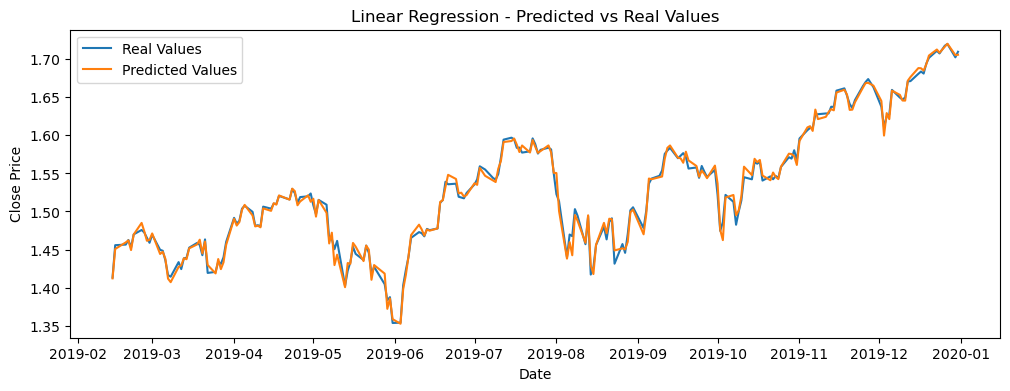

In [36]:
# Plotting the predicted values and real values
# Define time_window
# Define time_window
time_window = 30  # Adjust as needed

# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))

# Align dimensions
plt.plot(test_data.iloc[time_window:].index, y_test[time_window:], label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_test_pred[time_window:], label='Predicted Values')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()


In [38]:
# saving the prediction price for further use
y_pred_lr = get_y_pred_lr(regression_model, x_test, time_window)


## **ANN**

In [39]:
# Define the updated ANN model with Dropout
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)  # Increase to 256
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.4)  # Increase dropout to 40%

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)  # Additional dropout layer
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x

def split_data_x(data, time_window):
    """
    Prepare feature sequences for ANN using a sliding window.

    Args:
        data (pd.DataFrame): Scaled data containing features.
        time_window (int): Number of timesteps to include in each sequence.

    Returns:
        np.ndarray: Array of feature sequences.
    """
    x = []
    for i in range(len(data) - time_window):
        x.append(data.iloc[i:i + time_window].values)
    return np.array(x)

def split_data_y(data, time_window):
    """
    Prepare target values for ANN corresponding to the sequences.

    Args:
        data (pd.DataFrame): Scaled data containing the target variable.
        time_window (int): Number of timesteps to include in each sequence.

    Returns:
        np.ndarray: Array of target values.
    """
    y = data['Close'][time_window:].values
    return np.array(y)

In [40]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_val = split_data_x(validation_data_scaled, time_window)
y_val = split_data_y(validation_data, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [41]:
# transforming numpy to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [42]:
# Set the hyperparameters
hidden_size = 16
lr = 0.00001
num_iterations = 5000

# Reshape input data for ANN
x_train = x_train.reshape(x_train.shape[0], -1)  # Flatten input
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Define the model
input_size = x_train.shape[1]  # Adjust input size based on features
ann_model = ANNModel(input_size=input_size)

# Forward pass
outputs = ann_model(x_train)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.0001)

In [43]:
# Implement early stopping
early_stop_threshold = 10  # Stop if no improvement after 10 iterations
best_val_loss = float('inf')
no_improvement_count = 0

In [44]:
num_epochs = 5000
for epoch in range(num_epochs):
    ann_model.train()
    optimizer.zero_grad()
    outputs = ann_model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation step
    ann_model.eval()
    with torch.no_grad():
        val_outputs = ann_model(x_val)
        val_loss = criterion(val_outputs, y_val)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1579])) that is different to the input size (torch.Size([1579, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([373])) that is different to the input size (torch.Size([373, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping at epoch 89


In [45]:
# Ensure scaler is returned from split_data
train_data_scaled, validation_data_scaled, test_data_scaled, scaler = split_data(df)

# Fit a separate scaler for 'Close'
close_scaler = MinMaxScaler()
close_scaler.fit(train_data[['Close']])  # Fit only on the 'Close' column

# Compute predictions on the test data
y_pred = ann_model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

# Inverse transform the scaled y_pred values to get the actual predicted values
y_pred = close_scaler.inverse_transform(y_pred)

# Convert y_test tensor to a NumPy array for comparison
y_test = y_test.detach().numpy()



In [46]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 0.42415893
Root Mean Squared Error (RMSE): 0.42767146
Symmetric Mean Absolute Percentage Error (sMAPE): 16.078657
Mean Absolute Percentage Error (MAPE): 27.569958567619324


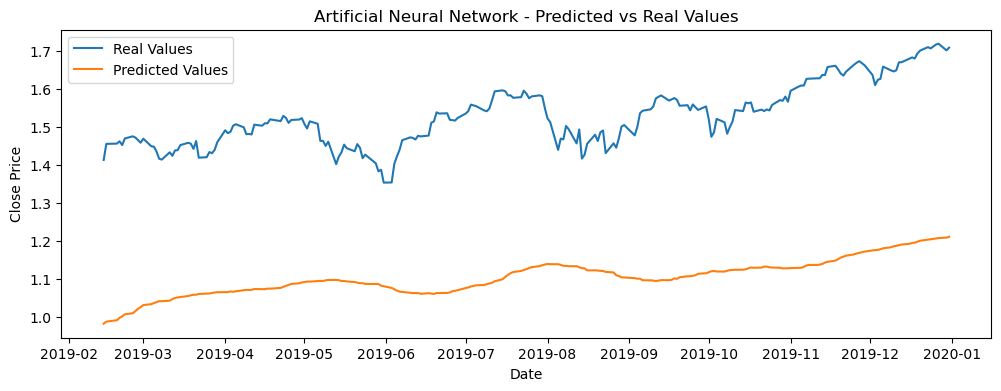

In [47]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [48]:
# Use get_y_pred_ann with close_scaler
y_pred_ann = get_y_pred_ann(ann_model, x_test, test_data, close_scaler, time_window)


# **LSTM**

In [49]:
# Define the updated LSTM model with increased hidden size and layers
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Get the last timestep output
        out = self.fc(out[:, -1, :])
        return out

In [50]:
# Instantiate model, criterion, and optimizer
lstm_model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Set up a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# Early stopping parameters
early_stop_threshold = 20
best_val_loss = float('inf')
no_improvement_count = 0

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [51]:
# Ensure x_train, x_val, and x_test have three dimensions
if x_train.dim() == 2:
    x_train = x_train.unsqueeze(-1)
if x_val.dim() == 2:
    x_val = x_val.unsqueeze(-1)
if x_test.dim() == 2:
    x_test = x_test.unsqueeze(-1)

In [52]:
# Set up DataLoader for batch processing
batch_size = 32
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [53]:
# Training loop with early stopping
num_epochs = 300
for epoch in range(num_epochs):
    lstm_model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation step
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(x_val)
        val_loss = criterion(val_outputs, y_val)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([373])) that is different to the input size (torch.Size([373, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they

Epoch [10/300], Training Loss: 0.07174032181501389, Validation Loss: 0.6324590444564819
Epoch [20/300], Training Loss: 0.07641230523586273, Validation Loss: 0.6284086108207703
Early stopping at epoch 29


In [54]:
y_pred_lstm = get_y_pred_lstm(lstm_model, x_test, test_data, close_scaler, time_window)


# **Hybrid Strategies**

## **Strategy 1**

![image.png](attachment:image.png)

### **hTEMA**

In [55]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows

    temp = df.copy() # Make a copy of the dataframe

    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [56]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm)


,DJI,ShortEMA,MidEMA,LongEMA,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,
2019-01-02,1.213254,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,1.150156,NaN,NaN,NaN,NaN,0,0,0,-0.053408,-0.000000,-0.063098,-0.000000,0.0,0.947993,1.000000,-0.063098,0.000000
2019-01-04,1.221563,NaN,NaN,NaN,NaN,0,0,0,0.060234,0.000000,0.071407,0.000000,0.0,1.006849,1.000000,0.008310,0.000000
2019-01-07,1.230950,NaN,NaN,NaN,NaN,0,0,0,0.007655,0.000000,0.009387,0.000000,0.0,1.014586,1.000000,0.017696,0.000000
2019-01-08,1.255433,NaN,NaN,NaN,NaN,0,0,0,0.019694,0.000000,0.024483,0.000000,0.0,1.034766,1.000000,0.042180,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.707430,1.672084,1.648831,1.625675,0.528001,1,1,1,-0.002018,-0.002018,-0.003449,-0.003449,0.0,1.407315,1.208065,0.494176,0.294071
2019-12-26,1.717558,1.676632,1.652546,1.628844,0.528112,1,1,1,0.005914,0.005914,0.010128,0.010128,0.0,1.415663,1.215231,0.504304,0.304199
2019-12-27,1.719840,1.680953,1.656184,1.631982,0.528196,1,1,1,0.001328,0.001328,0.002282,0.002282,0.0,1.417543,1.216846,0.506586,0.306481


#### **Comparing TEMA and hTEMA**

In [57]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,9.0,-0.122568,0.8894,-0.013619,-0.407079


In [84]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,0.296269,1.214763,0.296269,-0.179703


### **hMACD**

In [59]:
def hmacd_strategy(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe

    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [60]:
hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm)

,DJI,ShortEMA,LongEMA,MACD Line,Signal Line,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,,
2019-01-02,1.213254,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,1.150156,1.165931,NaN,NaN,NaN,NaN,0,0,0,-0.053408,-0.000000,-0.063098,-0.000000,0.0,0.947993,1.000000,-0.063098,0.000000
2019-01-04,1.221563,1.204446,NaN,NaN,NaN,NaN,0,0,0,0.060234,0.000000,0.071407,0.000000,0.0,1.006849,1.000000,0.008310,0.000000
2019-01-07,1.230950,1.222336,NaN,NaN,NaN,NaN,0,0,0,0.007655,0.000000,0.009387,0.000000,0.0,1.014586,1.000000,0.017696,0.000000
2019-01-08,1.255433,1.244492,NaN,NaN,NaN,NaN,0,0,0,0.019694,0.000000,0.024483,0.000000,0.0,1.034766,1.000000,0.042180,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.707430,1.707118,1.660630,0.046488,0.042518,0.528001,1,1,1,-0.002018,-0.002018,-0.003449,-0.003449,0.0,1.407315,1.208065,0.494176,0.294071
2019-12-26,1.717558,1.714078,1.664697,0.049382,0.044479,0.528112,1,1,1,0.005914,0.005914,0.010128,0.010128,0.0,1.415663,1.215231,0.504304,0.304199
2019-12-27,1.719840,1.717920,1.668635,0.049284,0.045852,0.528196,1,1,1,0.001328,0.001328,0.002282,0.002282,0.0,1.417543,1.216846,0.506586,0.306481


#### **Comparing MACD and hMACD**

In [61]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,38.0,0.1364,1.086911,0.003589,-0.324759


In [62]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,0.296269,1.214763,0.148135,-0.179703


## **hRSI**

In [63]:
def hrsi_strategy(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the Relative Strength Index (RSI) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    # Preprocess the dataframe
    df = df_change(df, symbol)  # Preprocess data (e.g., handle NaNs or changes)

    # Align `df` with `y_pred`
    adjusted_split = len(df) - len(y_pred)  # Find the index to align with predictions
    if adjusted_split < 0:
        # Trim y_pred to match df's length
        print(f"Trimming y_pred to match df length. Original y_pred length: {len(y_pred)}, df length: {len(df)}")
        y_pred = y_pred.iloc[-len(df):].reset_index(drop=True)
    else:
        # Trim df to align with y_pred
        df = df.iloc[adjusted_split:].reset_index(drop=True)

    # Ensure lengths match
    if len(df) != len(y_pred):
        print(f"Length mismatch after alignment: df={len(df)}, y_pred={len(y_pred)}")
        raise ValueError("Lengths of `df` and `y_pred` must match after alignment.")

    temp = df.copy()  # Make a copy of the aligned dataframe

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Determine strategy position based on RSI
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell when RSI > 70 (Overbought)
    )

    # Generate final trading signals by combining strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
        np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0)
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

# Test the function
result = hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm)

#### Comparing RSI and hRSI

In [64]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-0.062131,0.931497,-0.000875,-0.220887


In [65]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,0.296269,1.214763,0.148135,-0.179703


## **Strategy 2**

![image.png](attachment:image.png)

### **hTEMA**

In [66]:
def htema_strategy_2(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows

    temp = df.copy() # Make a copy of the dataframe

    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### **Comparing TEMA, hTEMA1, and hTEMA2**

In [67]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,9.0,-0.122568,0.8894,-0.013619,-0.407079


In [68]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,0.296269,1.214763,0.296269,-0.179703


In [69]:
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,10.0,-0.122568,0.8894,-0.012257,-0.407079


In [70]:
# Debug input
print(f"x_val shape before reshaping: {x_val.shape}")

# No need to squeeze; instead, verify it has the correct shape
if x_val.shape[1] != 3:  # Ensure 3 features: Open, High, Low
    x_val = x_val[:, :3]  # Retain the first three features (adjust as needed)

# Debug after adjustment
print(f"x_val shape after adjustment: {x_val.shape}")


x_val shape before reshaping: torch.Size([373, 120, 1])
x_val shape after adjustment: torch.Size([373, 3, 1])


In [71]:
print(f"x_val shape before reshaping: {x_val.shape}")

# Ensure x_val has the correct shape (2D)
x_val = x_val.reshape(x_val.shape[0], -1)

print(f"x_val shape after reshaping: {x_val.shape}")

# Generate predictions for validation data
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val),  # Ensure x_val is now 2D
    columns=['Predicted'],
    index=validation_data.index[-len(x_val):]  # Ensure index matches
)

# Adjust y_pred_val to match the length of validation_data
if len(y_pred_val) > len(validation_data):
    print("Trimming y_pred_val to match validation_data length")
    y_pred_val = y_pred_val.iloc[-len(validation_data):]

print("y_pred_val length after adjustment:", len(y_pred_val))
print("validation_data length:", len(validation_data))


# Run the strategy with the adjusted y_pred_val
print("Validation Set Metrics:")
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_val))


x_val shape before reshaping: torch.Size([373, 3, 1])
x_val shape after reshaping: torch.Size([373, 3])
y_pred_val length after adjustment: 373
validation_data length: 403
Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,21.0,0.882956,1.420797,0.042046,-0.263498


In [72]:
# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val),
    columns=['Predicted'],
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

print("Validation Set Metrics:")
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_val))

Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,21.0,0.882956,1.420797,0.042046,-0.263498


### **hMACD**

In [73]:
def hmacd_strategy_2(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe

    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### **Comparing MACD, hMACD1, and hMACD2**

In [74]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,38.0,0.1364,1.086911,0.003589,-0.324759


In [75]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,0.296269,1.214763,0.148135,-0.179703


In [76]:
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,38.0,0.1364,1.086911,0.003589,-0.324759


In [77]:
# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val),
    columns=['Predicted'],
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

print("Validation Set Metrics:")
calculate_metrics(hmacd_strategy(validation_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_val))

Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,40.0,1.342535,1.64485,0.033563,-0.117536


### **hRSI**

In [78]:
def hrsi_strategy_2(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the RSI (Relative Strength Index) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    # Preprocess data and align with predictions
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame to align with y_pred
    temp = df.copy()  # Create a copy of the trimmed DataFrame

    # Calculate RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and generate prediction positions
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Generate RSI-based strategy positions
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy if RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell if RSI > 70 (Overbought)
    )

    # Generate final trading signals using strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,  # Buy if both signals agree
        np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0)  # Sell if either signals sell
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### Comparing RSI, hRSI1, and hRSI2

In [79]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-0.062131,0.931497,-0.000875,-0.220887


In [80]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lr))

Trimming y_pred to match df length. Original y_pred length: 282, df length: 252


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,127.0,2.032975,6.627113,0.016008,-0.141515


In [81]:
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-0.062131,0.931497,-0.000875,-0.220887


In [82]:
# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val),
    columns=['Predicted'],
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

print("Validation Set Metrics:")
calculate_metrics(hrsi_strategy(validation_data, index_name, best_rsi_period, y_pred_val))


Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,54.0,0.780266,1.446934,0.014449,-0.263498
